# Travaux pratiques : Auto-Encodeurs (AE) et Auto-Encodeurs Variationnels (VAE)

**Auteur :**Benlahmar Habib


L'objectif de cette séance est d'explorer deux modèles fondamentaux de l'IA Générative : l'Auto-Encodeur (AE) classique et l'Auto-Encodeur Variationnel (VAE). Nous allons illustrer la construction d'un espace latent (ou espace de représentation compressée) et utiliser le VAE pour la génération de données synthétiques et l'interpolation dans cet espace.

Nous utiliserons la base de données Fashion-MNIST (images 28x28 en niveaux de gris), une alternative à MNIST.



# 📌 Préambule : Configuration et Chargement des Données

Nous allons commencer par configurer l'environnement PyTorch et charger le jeu de données.

In [1]:
import torch
# Utiliser le GPU si disponible (pour accélérer les calculs)
use_gpu = True 
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")
# Exécution sur cpu (ou cuda:0 si GPU disponible)

# Imports nécessaires
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import make_grid

Exécution sur cpu


## Chargement et Visualisation des Données

Fashion-MNIST contient 60 000 images d'entraînement et 10 000 images de test, chacune de $28 \times 28$ pixels.

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 738kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.09MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.37MB/s]


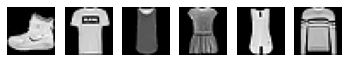

In [2]:
# Chargement des datasets. ToTensor() convertit l'image en un tenseur [0, 1]
train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

# Visualisation des premières images
n_images = 5
fig = plt.figure()
for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images + 1, i + 1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images:
        break
plt.show()

# I. Auto-Encodeur (AE) Classique
L'Auto-Encodeur est un réseau neuronal non supervisé conçu pour apprendre une représentation efficace (un code latent $\mathbf{z}$) de ses données d'entrée.

Principe : L'entrée $\mathbf{x}$ est encodée en $\mathbf{z}$, puis $\mathbf{z}$ est décodé en $\mathbf{x}'$. L'entraînement minimise l'erreur de reconstruction entre $\mathbf{x}$ et $\mathbf{x}'$.

Fonction de coût : Typiquement l'Erreur Quadratique Moyenne (MSE) : $\mathcal{L}(\mathbf{x}, \mathbf{x}') = ||\mathbf{x} - \mathbf{x}'||^2$.

1.1. Architecture et ImplémentationNous utiliserons une architecture convolutive (CNN) pour mieux capturer les caractéristiques spatiales des images. La dimension latente sera fixée à latent_dimension = 10.

* Encodeur (réduction de dimension) :Conv2d (1 -> 32) + ReLU : Réduit $28 \times 28$ à $14 \times 14$.Conv2d (32 -> 64) + ReLU : Réduit $14 \times 14$ à $7 \times 7$.Flatten : Transforme $64 \times 7 \times 7 = 3136$ en vecteur.Linear (3136 -> latent_dimension) : Produit le code latent $\mathbf{z}$.

* Décodeur (reconstruction) :Linear (latent_dimension -> 3136) + ReLU : Ramène la dimension du code à $3136$.View/Reshape : Transforme le vecteur $3136$ en $64 \times 7 \times 7$.ConvTranspose2d (64 -> 32) + ReLU : Remonte $7 \times 7$ à $14 \times 14$.ConvTranspose2d (32 -> 1) + Sigmoid : Remonte $14 \times 14$ à $28 \times 28$.


Note Pédagogique : La fonction Sigmoid finale garantit que les pixels de sortie $\mathbf{x}'$ restent dans la plage $[0, 1]$, correspondant à la plage de normalisation des images d'entrée.

## Implémentation de l'AutoEncoder
Complétez l'implémentation du AutoEncoder. La méthode forward() doit retourner à la fois la reconstruction $\mathbf{x}'$ (hat_x) et le code latent $\mathbf{z}$.

In [3]:
latent_dimension = 10

class AutoEncoder(nn.Module):
    def __init__(self, latent_dimension):
        super(AutoEncoder, self).__init__()
        # --- ENCODER ---
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=latent_dimension) # 3136 -> 10
        )
        # --- DÉCODEUR (Partie Linéaire) ---
        self.decoder_linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7) # 10 -> 3136
        
        # --- DÉCODEUR (Partie Convolutive) ---
        self.decoder = nn.Sequential(
            # On utilise ConvTranspose2d pour augmenter la résolution (l'inverse de Conv2d)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # 14x14 -> 28x28
            nn.Sigmoid(), # Pour s'assurer que les valeurs sont entre 0 et 1
        )

    def forward(self, x):
        # 1. Encodage: Réduction de dimension
        z = self.encoder(x)
        
        # 2. Décodage (étape linéaire et Reshape)
        hat_x = F.relu(self.decoder_linear(z))
        # Ré-arranger le tenseur pour l'entrée des convolutions transposées : (batch, 64, 7, 7)
        hat_x = hat_x.view(-1, 64, 7, 7) 
        
        # 3. Décodage (étape convolutive)
        hat_x = self.decoder(hat_x)
        
        return hat_x, z # Retourne reconstruction et code latent

net = AutoEncoder(latent_dimension)

## 1.2. Entraînement
Nous entraînons l'AE en minimisant l'erreur quadratique moyenne (nn.MSELoss) entre l'entrée et la sortie.

In [7]:
def train(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.MSELoss()
    net = net.to(device).train()

    t = trange(1, epochs + 1, desc="Entraînement de l'Auto-Encodeur")
    for epoch in t:
        avg_loss = 0.
        for images, _ in tqdm(train_dataloader):
            images = images.to(device)
            # Calcul de la reconstruction (on ignore le code latent _)
            reconstructions, _ = net(images) 
            loss = criterion(reconstructions, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net

net = train(net, train_dataset, epochs=10) # Décommenter pour lancer l'entraînement

Entraînement de l'Auto-Encodeur:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

## 1.3. Visualisation des Reconstructions et Débruitage
* Visualisation

Après l'entraînement, la qualité de la reconstruction nous donne une idée des performances du modèle.

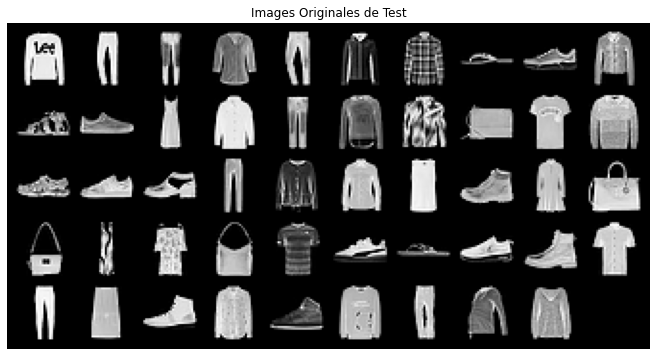

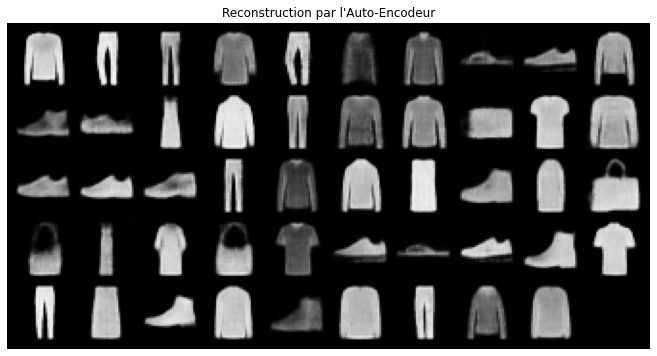

In [16]:
# Fonctions utilitaires de visualisation (fournies)
def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

def visualize_reconstructions(net, images, device=device):
    net = net.to(device).eval()
    with torch.no_grad():
        images = images.to(device)
        reconstructions = net(images)[0]
        # make_grid arrange les images en grille
        image_grid = make_grid(reconstructions[1:50], 10, 5).cpu() 
        return image_grid

test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
images, _ = next(iter(test_dataloader))

plt.figure(figsize=(12, 6))
plt.title("Images Originales de Test")
show_grid(make_grid(images[1:50],10,5))

plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'Auto-Encodeur")
show_grid(visualize_reconstructions(net, images))

### Débruitage

Un AE entraîné à reconstruire des images non bruitées apprend implicitement à ignorer le bruit, ce qui lui confère une capacité de débruitage (denoising).
### 📝 Ajout de Bruit Blanc
Complétez le code pour ajouter un bruit blanc uniforme aux images de test, en bornant les valeurs des pixels entre $0$ et $1$ (torch.clamp).

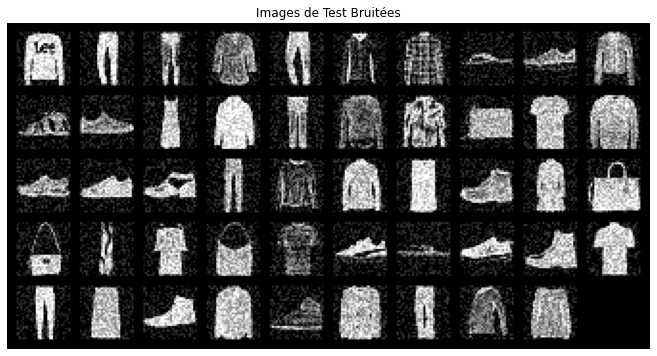

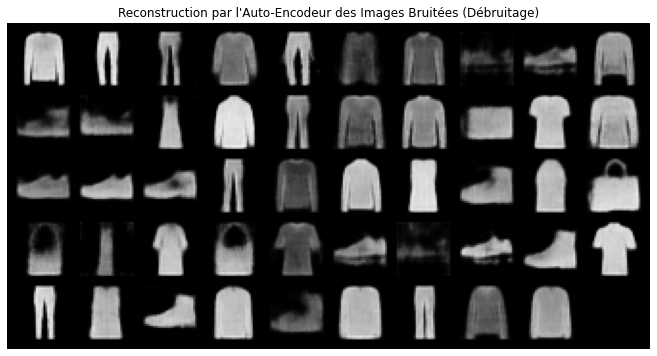

In [17]:
# Bruit blanc uniforme centré en 0 (entre -0.5 et 0.5)
noise = torch.rand_like(images) - 0.5 
# Amplitude du bruit : 0.5 est un bon point de départ pour l'expérience
noisy_images = torch.clamp(images + 0.5 * noise, 0, 1) 

plt.figure(figsize=(12, 6))
plt.title("Images de Test Bruitées")
show_grid(make_grid(noisy_images[1:50],10,5))

plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'Auto-Encodeur des Images Bruitées (Débruitage)")
show_grid(visualize_reconstructions(net, noisy_images))

Observation Attendue : Les images reconstruites à partir de noisy_images devraient paraître nettement moins bruitées que les entrées bruitées. L'AE agit comme un filtre passe-bas, ignorant les composantes à haute fréquence du bruit pour retrouver l'essence non bruitée de l'image compressée dans l'espace latent.

# II. Auto-Encodeur Variationnel (VAE)
Le VAE est une extension de l'AE qui, au lieu de compresser l'entrée $\mathbf{x}$ en un seul point latent $\mathbf{z}$, la mappe à une distribution de probabilité (une Gaussienne) dans l'espace latent.

## 2.1. Concepts Clés du VAE

* Espace Latent Continu et Régulier : Le VAE force la distribution des codes latents $q_{\phi}(\mathbf{z}|\mathbf{x})$ à être proche d'une distribution prior simple $p(\mathbf{z})$ (souvent une Gaussienne centrée réduite $\mathcal{N}(\mathbf{0}, \mathbf{I})$). Cela rend l'espace latent continu, facilitant l'échantillonnage et l'interpolation.
* Sortie de l'Encodeur : L'encodeur ne produit plus un vecteur $\mathbf{z}$ unique, mais deux vecteurs : la moyenne $\boldsymbol{\mu}$ et le log-variance $\log(\boldsymbol{\sigma}^2)$ de la distribution gaussienne $q_{\phi}(\mathbf{z}|\mathbf{x})$.
* Astuce de Reparamétrisation : Pour permettre la rétropropagation (car l'échantillonnage est une opération non-dérivable), le code latent $\mathbf{z}$ est calculé comme :$$\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}$$où $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ (bruit tiré d'une Gaussienne centrée réduite) et $\odot$ est la multiplication élément par élément.

## 2.2. Implémentation du VAE
### 📝 1. Définition de l'Encodeur et du Décodeur
L'Encodeur doit être modifié pour sortir deux vecteurs de taille latent_dimension: mu (moyenne) et logvar (log-variance).

In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        # Couches convolutives + Flatten (identique à l'AE)
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Flatten(),
        )
        # Couche linéaire pour la moyenne mu
        self.linear1 = nn.Linear(in_features=64*7*7, out_features=latent_dimension)
        # Couche linéaire pour le log-variance log(sigma^2)
        self.linear2 = nn.Linear(in_features=64*7*7, out_features=latent_dimension)

    def forward(self, x):
        x = self.model(x)
        x_mu = self.linear1(x)
        x_logvar = self.linear2(x) # On travaille avec le log-variance pour la stabilité numérique
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        # Le Décodeur est identique à celui de l'AE
        self.linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        hat_x = F.relu(self.linear(z))
        hat_x = hat_x.view(-1, 64, 7, 7)
        hat_x = self.model(hat_x)
        return hat_x

### 📝 2. Assemblage du VAE et Astuce de Reparamétrisation
La classe VariationalAutoencoder intègre l'encodeur, le décodeur et la méthode latent_sample pour appliquer l'astuce de reparamétrisation.

In [19]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        # 1. Échantillonnage du code latent
        z = self.latent_sample(latent_mu, latent_logvar)
        # 2. Décodage
        hat_x = self.decoder(z)
        return hat_x, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        # L'astuce de reparamétrisation
        if self.training:
            # 1. Calcul de l'écart-type: sigma = exp(0.5 * logvar)
            std = logvar.mul(0.5).exp_()
            # 2. Tirage du bruit epsilon ~ N(0, I)
            eps = torch.empty_like(std).normal_()
            # 3. Calcul de z: z = mu + sigma * epsilon
            return eps.mul(std).add_(mu)
        else:
            # En inférence/test, on utilise simplement la moyenne (le point le plus probable)
            return mu

### 2.3. La Fonction de Coût du VAE (ELBO)
Le VAE est entraîné en minimisant la fonction de coût qui est l'opposé de l'Evidence Lower Bound (ELBO), $\mathcal{L}$.$$\text{Loss} = - \mathcal{L} = \underbrace{-\mathbb{E}_{q_{\phi}(\boldsymbol z | \boldsymbol x)} \left [ \log p_{\theta}(\boldsymbol x | \boldsymbol z) \right ]}_{\text{Terme de Reconstruction (erreurs de pixels)}} + \underbrace{KL\, \left (q_{\phi}(\boldsymbol z | \boldsymbol x) \, || \, p(\boldsymbol z)\right)}_{\text{Divergence KL (régularisation)}}$$

* Terme de Reconstruction : Mesure la qualité de la reconstruction (similaire à l'AE). Puisque les pixels sont dans $[0, 1]$ (distribution bimodale), nous utilisons l'Entropie Croisée Binaire (BCE) à la place de la MSE pour de meilleurs résultats.
* Divergence de Kullback-Leibler (KL) : Force la distribution latente $q_{\phi}(\mathbf{z}|\mathbf{x})$ à se rapprocher de la prior $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$. Le terme analytique est :$$KL = \frac{1}{2} \sum_j^d \bigl ( 1 + \log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2 \bigr)$$où $d$ est la dimension latente, et $\mu_j$ et $\sigma_j^2$ sont les composantes des vecteurs $\boldsymbol{\mu}$ et $\boldsymbol{\sigma}^2$.

### 📝 Implémentation de vae_loss(avec $\beta$-VAE)
Le paramètre $\beta$ permet de pondérer l'importance de la divergence KL (régularisation).

In [20]:
beta = 1.0 # Paramètre du beta-VAE

def vae_loss(hat_x, x, mu, logvar):
    # Terme 1: Reconstruction Loss (BCE)
    # On met les images à plat (28*28) et on somme l'erreur pour chaque image du batch
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    
    # Terme 2: KL Divergence Loss
    # Utilise logvar = log(sigma^2)
    # L'expression KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Loss finale: Reconstruction + beta * KL
    return reconstruction_loss + beta * kl_divergence

### 2.4. Entraînement et Visualisation du VAE
##### Entraînement
La fonction d'entraînement est similaire à l'AE, mais elle prend en compte les trois sorties du forward() du VAE pour calculer la fonction de coût.

In [21]:
def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = vae_loss
    net = net.to(device).train()

    t = trange(1, epochs + 1, desc="Entraînement du VAE")
    for epoch in t:
        avg_loss = 0.
        for images, _ in tqdm(train_dataloader):
            images = images.to(device)
            # Récupère les 3 sorties: reconstruction, mu, logvar
            reconstructions, latent_mu, latent_logvar = net(images)
            
            # Calcul de l'erreur VAE
            loss = criterion(reconstructions, images, latent_mu, latent_logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu")

vae = VariationalAutoencoder(latent_dimension)
vae = train_vae(vae, train_dataset, epochs=10) # Décommenter pour lancer l'entraînement

Entraînement du VAE:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

### Visualisation des Reconstructions VAE

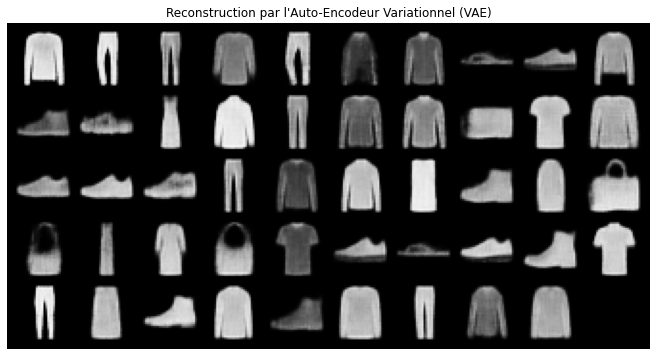

In [22]:
vae = vae.to("cpu")
images, _ = next(iter(test_dataloader))

plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'Auto-Encodeur Variationnel (VAE)")
show_grid(visualize_reconstructions(vae, images))

### 2.5. Génération et Interpolation (Le Cœur du VAE)
C'est là que le VAE se distingue de l'AE classique : son espace latent est conçu pour être continu et aligné sur la distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$, permettant la génération et l'interpolation de nouvelles données plausibles.

* 📝 Échantillonnage et Génération de Nouvelles Images

Pour générer des données, il suffit de tirer aléatoirement des vecteurs $\mathbf{z}$ de la distribution prior $\mathcal{N}(\mathbf{0}, \mathbf{I})$ et de les passer uniquement dans le décodeur.

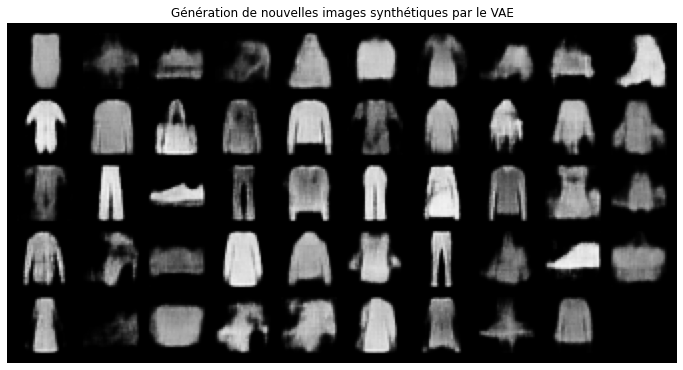

In [23]:
vae.eval()
with torch.no_grad():
    # Échantillonnage de 100 vecteurs latents selon une loi normale centrée réduite
    latent = torch.randn(100, latent_dimension, device=device) 
    
    # Décodage pour obtenir les images synthétiques
    # Accéder directement au décodeur est la façon de générer.
    fake_images = vae.decoder(latent).cpu() 

fig = plt.figure(figsize=(12, 12))
plt.title("Génération de nouvelles images synthétiques par le VAE")
show_grid(make_grid(fake_images[1:50], 10, 5))

#### 📝 Interpolation dans l'Espace Latent

Grâce à la régularisation de la divergence KL, le VAE garantit que l'espace latent est dense. En interpolant linéairement entre deux points $\mathbf{z}_1$ et $\mathbf{z}_2$, les points intermédiaires produisent des images qui se transforment graduellement et continûment.

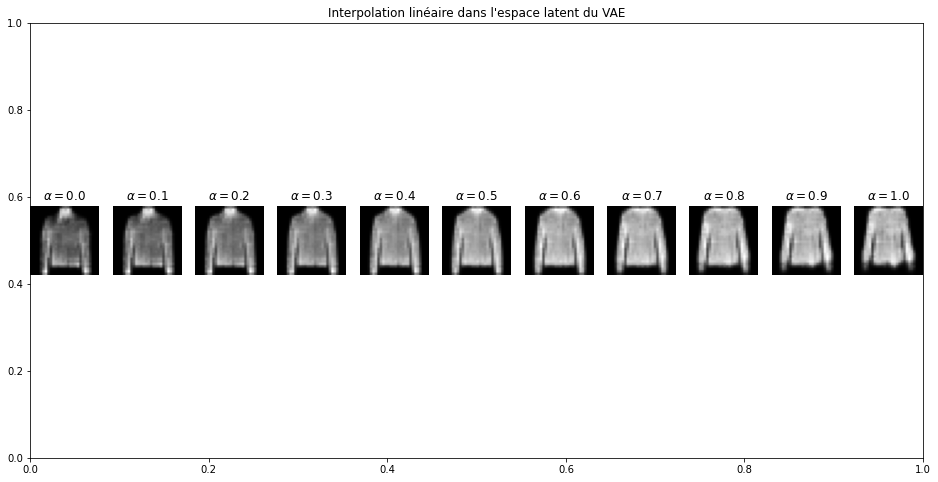

In [24]:
# z1 et z2 sont deux points aléatoires dans l'espace latent
z1 = torch.randn(1, latent_dimension, device=device)
z2 = torch.randn(1, latent_dimension, device=device)
n_steps = 10 # Nombre d'étapes d'interpolation

fig = plt.figure(figsize=(16, 8))
plt.title("Interpolation linéaire dans l'espace latent du VAE")

# Alpha parcourt l'intervalle [0, 1]
for idx, alpha in enumerate(np.linspace(0, 1, n_steps + 1)):
    # Interpolation: z = (1 - alpha) * z1 + alpha * z2
    z = (1 - alpha) * z1 + alpha * z2
    with torch.no_grad():
        # Décodage du point latent interpolé
        fake_image = vae.decoder(z)[0, 0, :, :].cpu().numpy()

    fig.add_subplot(1, n_steps + 1, idx + 1)
    plt.imshow(fake_image, cmap="gray")
    plt.title(f"$\\alpha = {alpha:0.1f}$")
    plt.axis('off')
plt.show()

##### Conclusion sur l'Interpolation : 
Contrairement à un AE classique (où l'interpolation passerait par des régions "vides" de l'espace latent, créant du bruit), le VAE produit une transition fluide et sémantiquement significative entre les deux images. Cela prouve l'efficacité de la régularisation par la Divergence KL.

# ❓ Questions d'Approfondissement pour le TP (AE & VAE)

## Niveau 1 : Conceptualisation et Distinction
Ces questions visent à vérifier la compréhension des principes fondamentaux.

* Distinction AE vs VAE : Quel est l'objectif principal de l'Auto-Encodeur (AE) classique, et en quoi l'Auto-Encodeur Variationnel (VAE) diffère-t-il fondamentalement ? Expliquez cette différence en termes de la nature de l'espace latent (point vs. distribution).
* Rôle de la Divergence KL : Dans la fonction de coût du VAE (ELBO), quel est le rôle précis du terme de Divergence de Kullback-Leibler (KL) ?  Que se passerait-il si ce terme était omis (c'est-à-dire si $\beta=0$) ?
* Génération de Contenu : Pourquoi peut-on générer de nouvelles images plausibles en échantillonnant aléatoirement l'espace latent du VAE, mais pas (ou très mal) avec l'AE classique ?
* Nature de la Perte de Reconstruction : Pourquoi préfère-t-on souvent l'Entropie Croisée Binaire (BCE) à l'Erreur Quadratique Moyenne (MSE) comme terme de reconstruction pour les images en niveaux de gris normalisées entre $[0, 1]$ ?

## Niveau 2 : Analyse Technique et Implémentation
Ces questions se concentrent sur les aspects techniques et l'implémentation.
* Astuce de Reparamétrisation : Expliquez en quoi consiste l'Astuce de Reparamétrisation et pourquoi elle est absolument nécessaire pour pouvoir entraîner le VAE par rétropropagation (backpropagation).
* Interprétation de $\mu$ et $\sigma$ : Dans le VAE, si pour une image donnée $\mathbf{x}$, l'encodeur calcule une moyenne $\boldsymbol{\mu}$ très proche de zéro et une variance $\boldsymbol{\sigma}^2$ très proche de zéro, qu'est-ce que cela signifie concernant le rôle de cette image dans la distribution globale des données ?
* Le $\beta$-VAE : Vous avez utilisé $\beta=1.0$ dans la fonction vae_loss. Si vous deviez augmenter $\beta$ (par exemple $\beta=5$), quel impact cela aurait-il sur la qualité de la reconstruction (le terme BCE) et sur la structure de l'espace latent (le terme KL) ? (Réponse : qualité de reconstruction dégradée, mais espace latent plus lisse et gaussien).
* Déconvolution (ConvTranspose2d) : Quel est le rôle de la couche ConvTranspose2d dans l'architecture du Décodeur, et comment est-elle l'analogue inverse de la couche Conv2d de l'Encodeur ?


### Niveau 3 : Synthèse, Ouverture et Réflexion
Ces questions sont des sujets de discussion pour aller au-delà du TP.
* Limites du VAE : Bien que le VAE permette une génération cohérente, il produit souvent des images plus floues que les GANs ou les Modèles de Diffusion. Quelle est la raison théorique derrière cette tendance à la "floutitude" (flou) dans les VAE ? (Indice : lié à l'utilisation de la MSE/BCE moyenne sur le batch).
* Application en Médecine : Imaginez que vous utilisez un VAE pour encoder des radiographies. Comment pourriez-vous utiliser la distance dans l'espace latent (entre $\mathbf{z}$ pour une nouvelle image et l'ensemble des $\mathbf{z}$ d'images saines) pour détecter une anomalie ou une maladie rare ?
* Comparaison d'Espaces Latents : Réfléchissez aux résultats de la projection t-SNE (si réalisée). Expliquez pourquoi l'interpolation linéaire entre deux points $\mathbf{z}_1$ et $\mathbf{z}_2$ a de bien meilleures chances de produire une transition sémantiquement significative dans le VAE que dans l'AE classique.
* Variantes Génératives : Citez et décrivez brièvement un autre modèle génératif majeur (par exemple, GAN ou Modèle de Diffusion). Comment ce modèle tente-t-il de résoudre le problème de la qualité de la génération d'images, et quelle est sa principale différence méthodologique avec le VAE ?